# Image Classification

## Introduction

This notebook was adapted from the one provided in https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5.

This notebook will walk you through the process of training and using a neural network for computer vision.

If you run the notebook as-is, it will automatically download a dataset of images of flowers, and will train a model to determine whether an image is of a sunflower or of a tulip.

However, to complete the assignment you will bring your own data, and use this notebook to train a model to distinguish between two (or more!) categories of images you provide. Instructions on how to do this are below.

The code in this notebook is by default mostly hidden, for clearer organization of the material. However, you can easily un-hide it by double-clicking on any code cell, if you would like to examine (or modify) the code.

Before running this notebook, make sure you're connected to a GPU! This will make training *much* faster. Click "Runtime" at the top, then "Change runtime type". If "Hardware Accelerator" isn't set to "GPU" or "T4 GPU", then change it.

## Assignment details

### Objective
Create your own unique custom image classifier.
### Estimated Time to Complete
30 minutes - 1hr

### Assignment Description
#### Beginner track
Using the notebook to create your own unique custom classifier, then test it out with a few images! Then submit your assignment following the instructions in the “Submission” section below.

#### Advanced track
Complete the beginner track, then find the model's accuracy on each of your image categories using the validation set. (This will require you to write some of your own code.) You should make a copy of this notebook (File:Save a Copy in Drive) and edit that copy so you can save your changes to the code.

### Submission (for all tracks)
Complete at least the beginner track above, then post in the New Student channel on Teams. In that post, provide the following:
* Describe your dataset
* Share a screengrab of your model outputs
* Note any interesting places where the model succeeded/failed.
* If you complete the advanced track, share your model validation results in your post.

In class, be prepared to discuss the following questions:
What kind of classifier did you create? Did it always work as you expected? What do you think are some potential applications for these services?



## Load code modules and data

In [1]:
#@title This cell loads the necessary software packages to run the rest of the notebook.

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import pathlib
from tensorflow.keras.utils import get_file
import os

Now it's time to load the data. If you don't use your own data, then the notebook will load the flower images and use those. To use your own data, you need to do the following.


1.   Acquire your data. You need at least two categories of images. They can be cats and dogs, or hot dogs and hamburgers, or turtles and tortoises, or anything you like. The more data the better -- your model will perform better and better the more data you can feed it. The flowers data has around 2000 images, and this is still a very small dataset in the area of computer vision! But you should try to get, at a bare minimum, 20 images per category.
2.   Put your data on your Google Drive account, in the following structure: each category will have its own folder, named for the category, containing all the images of that category (and nothing else!). All of these category folders should be in one parent folder. So, for example, you could have a "flowers" folder which contains two subfolders, one called "sunflowers" and one called "tulips".
3. Check the box below labeled: "use_own_data".
4. Run the below code cell. You will be prompted to authenticate the notebook to access your Google Drive. Afterward, your Drive will be mounted at '/gdrive' and accessible here. You will then be prompted to provide the file path to your data's parent folder (the folder with all your individual category folders in it). Using the sidebar on the left, navigate to your data's parent folder, and right-click it (or click the menu icon for the folder) and select "copy path". Paste the filepath in the prompt.
5. Run the rest of the notebook as-is.



In [6]:
#@title Choose data source: flowers, or your own data

use_own_data = True #@param {type:"boolean"}

if use_own_data:
  from google.colab import drive
  drive.mount('/gdrive')
  filepath = input("Paste the file path for the data here:")
  data_dir = pathlib.Path(filepath)
  if os.path.isdir(data_dir):
    print("Data folder loaded!")
  else:
    print("Error: Data folder not found.")
else:
  dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
  data_dir = get_file('flower_photos', origin=dataset_url, untar=True)
  data_dir = pathlib.Path(data_dir)
  # Let's look at two-category classification.
  # So, we delete everything except two of the categories in the data.
  # (You can comment out the remainder of this cell out to do 5-category classification.)
  for dir in data_dir.iterdir():
    if str(dir).split('/')[-1] not in ['sunflowers','tulips']:
      if dir.is_dir():
        for item in dir.iterdir():
          item.unlink()
        dir.rmdir()
      else:
        dir.unlink()

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Paste the file path for the data here:/gdrive/MyDrive/decades
Data folder loaded!


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prepare the data

In this section, we provide some pre-processing to help the model get as much as possible out of the data. We also need to standardize the size of the images.

In [7]:
#@title Define transformations to be performed on the images

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
# These normalizations are a good idea, but are omitted here just because they
# make it a bit more complicated to demonstrate the model's output.
                                      #  transforms.Normalize([0.485, 0.456, 0.406],
                                      #                       [0.229, 0.224, 0.225])
                                       ])

test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      # transforms.Normalize([0.485, 0.456, 0.406],
                                      #                   [0.229, 0.224, 0.225])
                                      ])

In [8]:
#@title Split the data into training and validation sets; print categories

def load_split_train_test(datadir,
                          valid_size = .2,
                          train_transforms = train_transforms,
                          test_transforms = test_transforms):

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)


['1900s', '1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s']


## Prepare the model

Here we load the pre-trained ResNet50 model, and prepare it to be fine-tuned on the current dataset.

In [9]:
#@title Check for GPU, and load the pre-trained ResNet50 model

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  print("You aren't connected to a GPU -- training may be slow!")
  device = torch.device("cpu")
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 117MB/s]


In [10]:
#@title Attach a "head" to the model that will let it perform the specific desired classification; display the model

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

num_classes = len(trainloader.dataset.classes)

model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, num_classes),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Model training

This section is where we actually train the model. The model will study each image in your dataset, multiple times -- the number of times is set by `epoch`, which you can change in the cell below. Be aware that (depending on the size of your dataset) a high number of epochs could be very slow to train!

Periodically during the training process, you'll get updates about how the training process is going. The model's "loss" should tend to go down, and its "accuracy" should tend to go up. This means the model is learning from the training data to make better classifications.

In [11]:
#@title Prepare to train the model

epochs = 25 #@param {type:"integer"}
steps = 0
running_loss = 0
print_every = np.min([len(testloader),10])
train_losses, test_losses = [], []
best_valid_loss = float('inf')
model_path = 'classification_model.pt' # This is where we'll save the model

In [12]:
#@title Train the model!

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {test_loss/len(testloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(testloader):.3f}")

            # If this is the best performance we've seen yet on the validation
            # set, then save this model.
            if test_loss < best_valid_loss:
              best_valid_loss = test_loss
              torch.save(model.state_dict(), model_path)

            running_loss = 0
            model.train()

Epoch 1/25.. Train loss: 4.267.. Validation loss: 2.317.. Validation accuracy: 0.078
Epoch 1/25.. Train loss: 2.611.. Validation loss: 2.026.. Validation accuracy: 0.387
Epoch 1/25.. Train loss: 1.935.. Validation loss: 1.809.. Validation accuracy: 0.365


KeyboardInterrupt: 

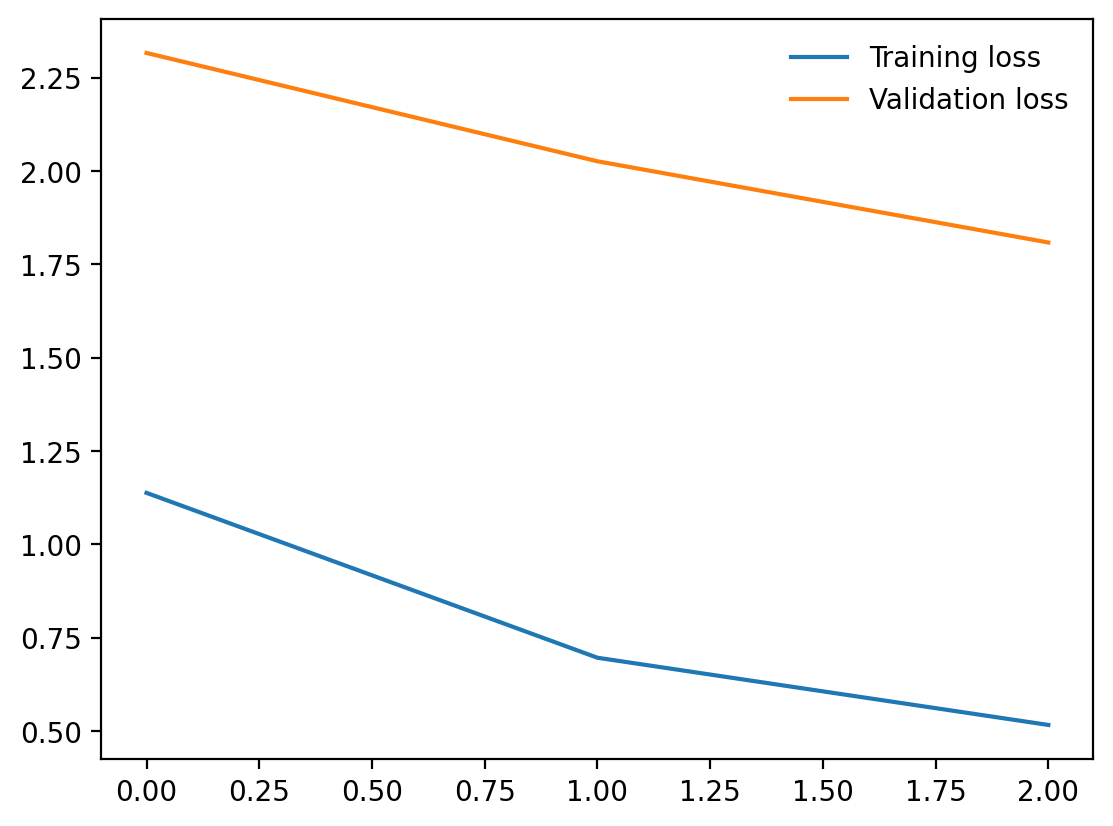

In [13]:
#@title Examine the loss curves over the training process

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

## Use the trained model!

Now that our model is trained, let's see it in action!

Because of "overfitting", which we'll discuss later in the course, the model might have first improved but then gotten *worse* toward the end of the training process. So, first we'll load the best version of our model that appeared during training, rather than just using the version from the very end of the training process.

Next, we'll pick some random images from the validation set, and see how the model labels them, along with whether the model was right or wrong. Since these images are from the *validation* set, the model didn't use them for training, so this is a good guide to how the model would perform "in the wild". You can run the final code cell as many times as you like to see different randomly selected images from your validation set. (Each time you do, the resulting images and classifications will be saved as "`results.png`"; you can download this image for submission.)

In [14]:
#@title Load the model
%%capture
model.load_state_dict(torch.load(model_path))
model.eval()

In [15]:
#@title Define helper functions for us to use the model
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num, loader=testloader):
    data = next(iter(loader))
    images = data[0][:num]
    labels = data[1][:num]
    return images, labels

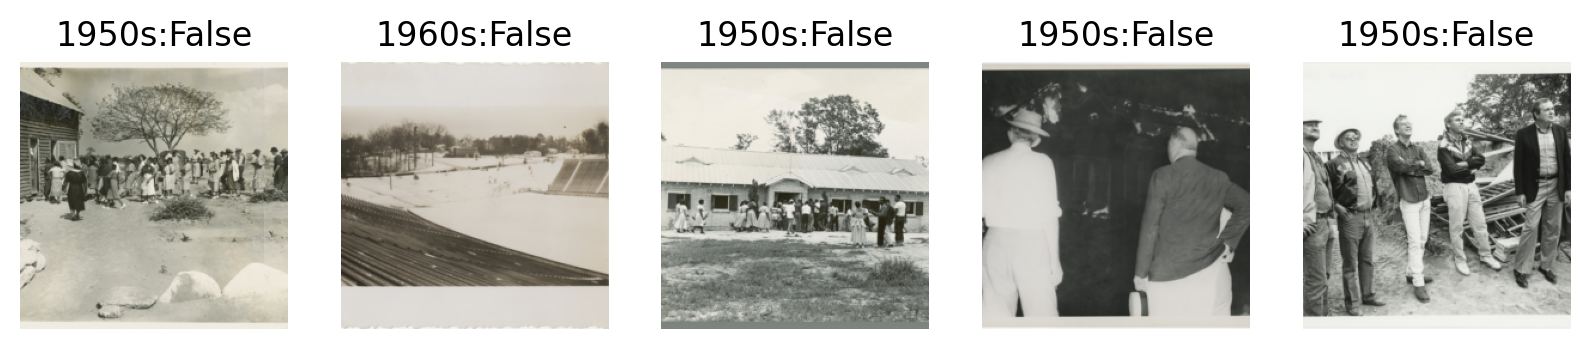

In [16]:
#@title Look at the model's performance on some images from the validation set!
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(trainloader.dataset.classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.savefig('results.png',bbox_inches='tight')

plt.show()

In [17]:
from google.colab import files
files.download('classification_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Advanced track (optional): find model accuracy in each category

"""
Write code here that shows the accuracy of the model for each of your
image categories. (Be sure to evaluate your model on the validation set,
not on the training set.)
"""

## Want a bigger challenge?

If you want to delve even deeper into the use of neural networks for computer vision, here are a couple of things to try.

  1. The above code, when pre-processing the images, does not *normalize* them. Normalization of the images would involve subtracting from each color channel the mean value of that color channel across all images, and then dividing the result by the standard deviation of the value of that color channel across all images. This is generally considered helpful to the model, and is omitted here purely for convenience. So: having completed the advanced track above, try adding normalization to the pre-processing and then re-evaluate the resulting models' accuracy. How much does the accuracy change by virtue of adding this preprocessing step?
  2. The above code uses a pre-trained version of the ResNet50 model. This model is pre-trained on millions of images, which makes it relatively easy to fine-tune as we did here. Instead of starting with a pre-trained version, modify the code to use a randomly initialized model (a version with no pre-training at all). See what kind of performance you can get by training this model. (Spoiler -- it will be very hard to train such a model to perform well!) Alternatively or in addition, find a much, much smaller model than ResNet50 and load a non-pre-trained version of that model, then train it. It will still be hard, but training a smaller model from scratch will be much easier than trying to train a (huge) ResNet50 model from scratch.

If you attempt one of these challenges, let us know in your Teams channel submission how it went!